<a href="https://colab.research.google.com/github/oaarnikoivu/dissertation/blob/master/Attention_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install transformers

# Imports

In [2]:
import torch
import random
import transformers
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from pathlib import Path
from torchtext import data
from transformers import BertTokenizer, BertModel

# Arguments

In [0]:
args = {
    "bert_tokenizer": "bert-base-uncased",
    "bert_pretrained_model": "bert-base-uncased",
    "seed": 1234,
    "embedding_dim": 768,
    "batch_size": 64,
    "output_dim": 11,
    "hidden_size": 768,
    "num_layers": 2,
    "dropout": 0.5,
    "fc_dropout": 0.5,
    "embed_dropout": 0.2,
    "weight_decay": 1e-5,
    "lr": 0.001,
    "epochs": 10
}

# Setup Bert Tokenizer

In [0]:
tokenizer = BertTokenizer.from_pretrained(args['bert_tokenizer'])

In [85]:
max_input_length = tokenizer.max_model_input_sizes[args['bert_tokenizer']]

print(max_input_length)

512


In [0]:
def tokenize(tweet):
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  return tokens

# Load and Generate Data

In [0]:
file_path = '/content/drive/My Drive'

DATA_PATH = Path(file_path + '/datasets/SemEval')

random.seed(args['seed'])
np.random.seed(args['seed'])
torch.manual_seed(args['seed'])
torch.backends.cudnn.deterministic = True

TEXT = data.Field(batch_first = True,
                  use_vocab = False,
                  tokenize = tokenize,
                  preprocessing = tokenizer.convert_tokens_to_ids,
                  init_token = tokenizer.cls_token_id,
                  eos_token = tokenizer.sep_token_id,
                  pad_token = tokenizer.pad_token_id,
                  unk_token = tokenizer.unk_token_id)

LABEL = data.LabelField(sequential = False,
                        use_vocab = False,
                        pad_token= None,
                        unk_token = None, 
                        dtype = torch.float)

dataFields = {"Tweet": ("Tweet", TEXT),
              'anger': ("anger", LABEL),
              'anticipation': ("anticipation", LABEL),
              'disgust': ("disgust", LABEL),
              'fear': ("fear", LABEL),
              'joy': ("joy", LABEL),
              'love': ("love", LABEL),
              'optimism': ("optimism", LABEL),
              'pessimism': ("pessimism", LABEL),
              'sadness': ("sadness", LABEL),
              'surprise': ("surprise", LABEL),
              'trust': ("trust", LABEL)}

train_data, valid_data, test_data = data.TabularDataset.splits(
    path = DATA_PATH,
    train = 'train.csv',
    validation = 'val.csv',
    test = 'test.csv',
    format = 'csv',
    fields = dataFields
)

In [0]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
    (train_data, valid_data, test_data),
    sort_key = lambda x: len(x.Tweet),
    sort_within_batch = True,
    batch_size = args['batch_size'],
    device = device
)

# Batch Wrapper

In [0]:
LABEL_COLS = ['anger', 'anticipation', 'disgust', 'fear', 'joy', 
              'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']

iaux = 0

for batch in valid_iterator:
  iaux += 1
  aux = batch
  aux2 = torch.stack([getattr(batch, label) for label in LABEL_COLS])
  if aux == 20: break;

# Build the Model

Load the pretrained bert model from the HuggingFace transformers library.

https://github.com/huggingface/transformers

In [0]:
bert = BertModel.from_pretrained(args['bert_pretrained_model'])

Setup the model architecture proposed at: https://www.aclweb.org/anthology/P16-2034/

In [0]:
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()
    self.attention = nn.Linear(hidden_size, 1)

  def forward(self, x):
    x = torch.tanh(x)
    x = self.attention(x).squeeze(2)
    alpha = F.softmax(x, dim=1).unsqueeze(1)
    return alpha

class AttentionBiLSTM(nn.Module):
  def __init__(self, bert, hidden_size, num_layers, dropout, fc_dropout, 
               embed_dropout, num_classes):
    super(AttentionBiLSTM, self).__init__()

    self.hidden_size = hidden_size 
    self.bert = bert 
    embedding_dim = args['embedding_dim'] 

    self.embed_dropout = nn.Dropout(embed_dropout)

    self.bilstm = nn.LSTM(embedding_dim, 
                          hidden_size, 
                          num_layers, 
                          dropout=(0 if num_layers==1 else dropout),
                          bidirectional=True,
                          batch_first=True)
    
    self.fc = nn.Linear(hidden_size, num_classes)
    self.fc_dropout = nn.Dropout(fc_dropout)
    
    self.attention = Attention(hidden_size)
  
  def forward(self, text):
    with torch.no_grad():
      x = self.bert(text)[0]
    
    x = self.embed_dropout(x)
    y, _ = self.bilstm(x)
    y = y[:,:,:self.hidden_size] + y[:,:,self.hidden_size:]
    alpha = self.attention(y)
    r = alpha.bmm(y).squeeze(1)
    h = torch.tanh(r)
    logits = self.fc(h)
    logits = self.fc_dropout(logits)
    return logits, alpha 

In [92]:
model = AttentionBiLSTM(
    bert=bert,
    hidden_size=args['hidden_size'],
    num_layers=args['num_layers'],
    dropout=args['dropout'],
    fc_dropout=args['fc_dropout'],
    embed_dropout=args['embed_dropout'],
    num_classes=args['output_dim'],
)

model

AttentionBiLSTM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tr

Freeze the parameters which are a part of the Bert Transformers model. 

In [0]:
for name, param in model.named_parameters():                
    if name.startswith('bert'):
        param.requires_grad = False

Show the trainable parameters.

In [94]:
for name, param in model.named_parameters():                
    if param.requires_grad:
        print(name)

bilstm.weight_ih_l0
bilstm.weight_hh_l0
bilstm.bias_ih_l0
bilstm.bias_hh_l0
bilstm.weight_ih_l0_reverse
bilstm.weight_hh_l0_reverse
bilstm.bias_ih_l0_reverse
bilstm.bias_hh_l0_reverse
bilstm.weight_ih_l1
bilstm.weight_hh_l1
bilstm.bias_ih_l1
bilstm.bias_hh_l1
bilstm.weight_ih_l1_reverse
bilstm.weight_hh_l1_reverse
bilstm.bias_ih_l1_reverse
bilstm.bias_hh_l1_reverse
fc.weight
fc.bias
attention.attention.weight
attention.attention.bias


# Train the Model

In [0]:
import torch.optim as optim 

In [0]:
optimizer = optim.Adam(model.parameters(), weight_decay=args['weight_decay'])
criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

We evaluate using the Jaccard index and the macro and micro F1's as there are more suitable for multi-label text classification problems.

In [0]:
from sklearn.metrics import roc_auc_score, f1_score, jaccard_similarity_score

In [0]:
def metricize(preds, y):
  f1_macro = f1_score(y, preds.round(), average='macro')
  f1_micro = f1_score(y, preds.round(), average='micro')
  #acc = roc_auc_score(y, preds)
  acc = jaccard_similarity_score(y, preds.round())

  return {
      'f1_macro': f1_macro,
      'f1_micro': f1_micro,
      'acc': acc
  }

In [0]:
def train(model, iterator, optimizer, criterion):

  epoch_loss = 0

  model.train()

  preds_list = []
  labels_list = []

  for i, batch in enumerate(iterator):
    
    optimizer.zero_grad()

    predictions, _ = model(batch.Tweet)

    batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
    batch_labels = torch.transpose(batch_labels, 0, 1)

    loss = criterion(predictions, batch_labels)

    loss.backward()

    optimizer.step()

    preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
    labels_list += [batch_labels.cpu().numpy()]

    epoch_loss += loss.item()
  
  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
def evaluate(model, iterator, criterion):

  epoch_loss = 0

  model.eval()

  preds_list = []
  labels_list = []

  with torch.no_grad():
    
    for batch in iterator:

      predictions, _ = model(batch.Tweet)

      batch_labels = torch.stack([getattr(batch, label) for label in LABEL_COLS])
      batch_labels = torch.transpose(batch_labels, 0, 1)

      loss = criterion(predictions, batch_labels)

      epoch_loss += loss.item()

      preds_list += [torch.sigmoid(predictions).detach().cpu().numpy()]
      labels_list += [batch_labels.cpu().numpy()]

  return epoch_loss / len(iterator), metricize(np.vstack(preds_list),
                                             np.vstack(labels_list))

In [0]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

We train the model for 10 epochs and record the training and validation loss. 

In [102]:
best_valid_loss = float('inf')

train_history = []
valid_history = []

for epoch in range(args['epochs']):

    start_time = time.time()
    
    train_loss, train_metrics = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_metrics = evaluate(model, valid_iterator, criterion)

    train_history.append(train_loss)
    valid_history.append(valid_loss)
    
    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'bert-lstm-model.pt')

    train_acc = train_metrics['acc']
    train_micro = train_metrics['f1_micro']
    train_macro = train_metrics['f1_macro']

    valid_acc = valid_metrics['acc']
    valid_micro = valid_metrics['f1_micro']
    valid_macro = valid_metrics['f1_macro']
    
    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}% | Train F1 Micro: {train_micro*100:.2f}% | Train F1 Macro: {train_macro*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} | Val. Acc: {valid_acc*100:.2f}%  | Val. F1 Micro: {valid_micro*100:.2f}%  | Val. F1 Macro: {valid_macro*100:.2f}%')

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


Epoch: 01 | Epoch Time: 0m 24s
	Train Loss: 0.553 | Train Acc: 19.18% | Train F1 Micro: 28.78% | Train F1 Macro: 17.95%
	 Val. Loss: 0.430 | Val. Acc: 45.44%  | Val. F1 Micro: 58.06%  | Val. F1 Macro: 35.76%
Epoch: 02 | Epoch Time: 0m 24s
	Train Loss: 0.525 | Train Acc: 24.55% | Train F1 Micro: 35.06% | Train F1 Macro: 23.23%
	 Val. Loss: 0.392 | Val. Acc: 49.32%  | Val. F1 Micro: 61.92%  | Val. F1 Macro: 40.49%
Epoch: 03 | Epoch Time: 0m 25s
	Train Loss: 0.515 | Train Acc: 26.95% | Train F1 Micro: 38.24% | Train F1 Macro: 26.87%
	 Val. Loss: 0.378 | Val. Acc: 49.28%  | Val. F1 Micro: 62.17%  | Val. F1 Macro: 40.42%
Epoch: 04 | Epoch Time: 0m 25s
	Train Loss: 0.506 | Train Acc: 27.71% | Train F1 Micro: 39.58% | Train F1 Macro: 28.10%
	 Val. Loss: 0.383 | Val. Acc: 51.08%  | Val. F1 Micro: 64.49%  | Val. F1 Macro: 46.08%
Epoch: 05 | Epoch Time: 0m 25s
	Train Loss: 0.505 | Train Acc: 27.93% | Train F1 Micro: 39.84% | Train F1 Macro: 28.80%
	 Val. Loss: 0.382 | Val. Acc: 53.34%  | Val. F1

# Visualize the training and validation loss 

In [0]:
import matplotlib.pyplot as plt

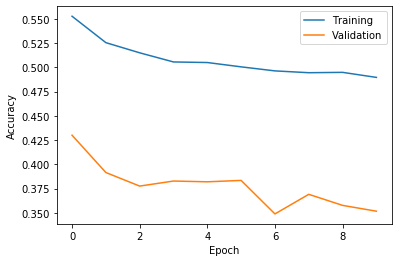

In [104]:
plt.plot(train_history)
plt.plot(valid_history)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training', 'Validation'])

# Assess model performance on testing data

In [105]:
model.load_state_dict(torch.load('bert-lstm-model.pt'))

test_loss, test_metrics = evaluate(model, test_iterator, criterion)

test_acc = test_metrics['acc']
test_micro = test_metrics['f1_micro']
test_macro = test_metrics['f1_macro']

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}% | Test F1 Micro: {test_micro*100:.2f}% | Test F1 Macro: {test_macro*100:.2f}%')

Test Loss: 0.346 | Test Acc: 54.87% | Test F1 Micro: 66.52% | Test F1 Macro: 46.12%


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:664: FutureWarning: jaccard_similarity_score has been deprecated and replaced with jaccard_score. It will be removed in version 0.23. This implementation has surprising behavior for binary and multiclass classification tasks.
  FutureWarning)


# Inference

In [0]:
def predict_emotion(model, tokenizer, tweet):
  preds = []
  model.eval()
  tokens = tokenizer.tokenize(tweet)
  tokens = tokens[:max_input_length-2]
  indexed = [init_token_idx] + tokenizer.convert_tokens_to_ids(tokens) + [eos_token_idx]
  tensor = torch.LongTensor(indexed).to(device)
  tensor = tensor.unsqueeze(0)
  predictions, attn_weights = model(tensor)
  preds.append(torch.sigmoid(predictions).detach().cpu().numpy())
  return preds, attn_weights, tokens

Lets test the model on our own input and save the attention weights and tokens for visualization. 

In [109]:
preds, attn_weights, tokens = predict_emotion(model, tokenizer, 
                                              "Good music, I love that shit.")

vals = []
for p in preds[0]:
  for val in p:
    vals.append(val)

for i, label in enumerate(LABEL_COLS):
  print(f"{label.upper()}: {vals[i]}")

ANGER: 0.3511693477630615
ANTICIPATION: 0.12626828253269196
DISGUST: 0.2717917561531067
FEAR: 0.1034935787320137
JOY: 0.8128243088722229
LOVE: 0.48896071314811707
OPTIMISM: 0.559106171131134
PESSIMISM: 0.06569769978523254
SADNESS: 0.11318326741456985
SURPRISE: 0.09305175393819809
TRUST: 0.2579237222671509


Here we format the attention weights and store the results in a dictionary

In [110]:
aws = []
for a in attn_weights[0]:
  for v in a:
    aws.append(v.detach().cpu().numpy())

aws = aws[1:-1]
aws = np.array(aws)
aws

array([0.06429043, 0.01932916, 0.02743982, 0.04082123, 0.67441005,
       0.02125979, 0.13989049, 0.00411803], dtype=float32)

In [111]:
attn_dict = {}
for i in range(len(aws)):
  attn_dict[tokens[i]] = aws[i]

print(attn_dict)

{'good': 0.064290434, 'music': 0.019329157, ',': 0.02743982, 'i': 0.04082123, 'love': 0.67441005, 'that': 0.021259792, 'shit': 0.13989049, '.': 0.004118027}


Lets return the top 3 words that the model focused on. 

In [0]:
from collections import Counter

In [113]:
Counter(attn_dict).most_common(3)

[('love', 0.67441005), ('shit', 0.13989049), ('good', 0.064290434)]